# Extreme-Correction applied to Hs and Tp

Extreme correction technique applied to Hs and Tp from Santoña.

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF

os.chdir(r"c:\Users\user\Victor\Trabajo\ExtremeCorrection")
from src.extr_corr import ExtremeCorrection

# Load Data

In [2]:
historical_dataset = xr.open_dataset("Data/DatosJared/Wave_families_santona_daily.nc")
sampled_dataset = xr.open_dataset("Data/DatosJared/simulated_waves.nc").rename({"bulk_Hs": "Hs", "bulk_Tp": "Tp", "bulk_Dir": "Dir"})

In [3]:
historical_dataset

<xarray.Dataset>
Dimensions:      (time: 14610)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    sea_Hs       (time) float32 ...
    sea_Tp       (time) float32 ...
    sea_Dir      (time) float32 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    Hs           (time) float32 ...
    Tp           (time) float32 ...
    Dir          (time) float32 ...
    bmus         (time) int64 ...

In [4]:
sampled_dataset

<xarray.Dataset>
Dimensions:  (n_sim: 1, time: 36891)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    DWT      (n_sim, time) int64 ...
    Hs       (n_sim, time) float64 ...
    Tp       (n_sim, time) float64 ...
    Dir      (n_sim, time) float64 ...

Asumo que bmus tiene los WT, sino habria que cogerlos de la siguiente forma:

In [5]:
df_hist = historical_dataset.to_dataframe().loc[:,["Hs", "Tp", "Dir"]]
df_hist["yyyy"] = df_hist.index.year
df_hist["mm"] = df_hist.index.month
df_hist["dd"] = df_hist.index.day
df_hist = df_hist.reset_index()
df_hist["time"] = df_hist.index / 365.25
df_hist.head()

,time,Hs,Tp,Dir,yyyy,mm,dd
0,0.000000,1.023583,4.836266,185.625000,1979,1,1
1,0.002738,1.341333,5.067072,89.291664,1979,1,2
2,0.005476,1.855333,6.305674,126.416664,1979,1,3
3,0.008214,4.830250,11.519656,282.291656,1979,1,4
4,0.010951,2.902167,11.920074,305.916656,1979,1,5


In [6]:
df_sim = sampled_dataset.sel(n_sim=0).to_dataframe().loc[:,["Hs", "Tp", "Dir"]]
df_sim["yyyy"] = df_sim.index.year
df_sim["mm"] = df_sim.index.month
df_sim["dd"] = df_sim.index.day
df_sim = df_sim.reset_index()
df_sim["time"] = df_sim.index / 365.25
df_sim.head()

,time,Hs,Tp,Dir,yyyy,mm,dd
0,0.000000,1.750975,8.529534,283.245014,1999,1,1
1,0.002738,1.627966,8.854106,299.305291,1999,1,2
2,0.005476,2.761744,9.576388,329.714930,1999,1,3
3,0.008214,2.325261,14.954787,306.216905,1999,1,4
4,0.010951,1.819668,16.823529,288.421431,1999,1,5


# Hs

Init threshold of quantile 0.98

In [7]:
np.quantile(df_hist["Hs"], 0.98)

5.4903304195404035

In case we want to use the minimum AM value of $H_s$ as init threshold

In [8]:
df_hist.groupby(["yyyy"])["Hs"].max().min()

5.910250186920166

In [9]:
config = {
    'var': "Hs",
    'time_var': 'time',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 365.242,
    'folder': 'Figures/SantonaMinAM/Hs'
}

pot_config = {
    'n0': 10,
    'min_peak_distance': 2,
    'init_threshold': df_hist.groupby(["yyyy"])["Hs"].max().min(),
    'siglevel': 0.01,
    'plot_flag': True
}

extr_corr_complete = ExtremeCorrection(
    data_hist = df_hist,
    data_sim = df_sim[:-1],
    config=config,
    pot_config=pot_config,
    method="POT",
    conf_level=0.95,
    random_state=0
)

Poisson parameters difference: 3.1314101323486274


In [10]:
extr_corr_complete.opt_threshold

5.916083812713623

In [11]:
ecdf_hist_hs = ECDF(df_hist["Hs"])
ecdf_hist_hs(extr_corr_complete.opt_threshold)

0.987337440109514

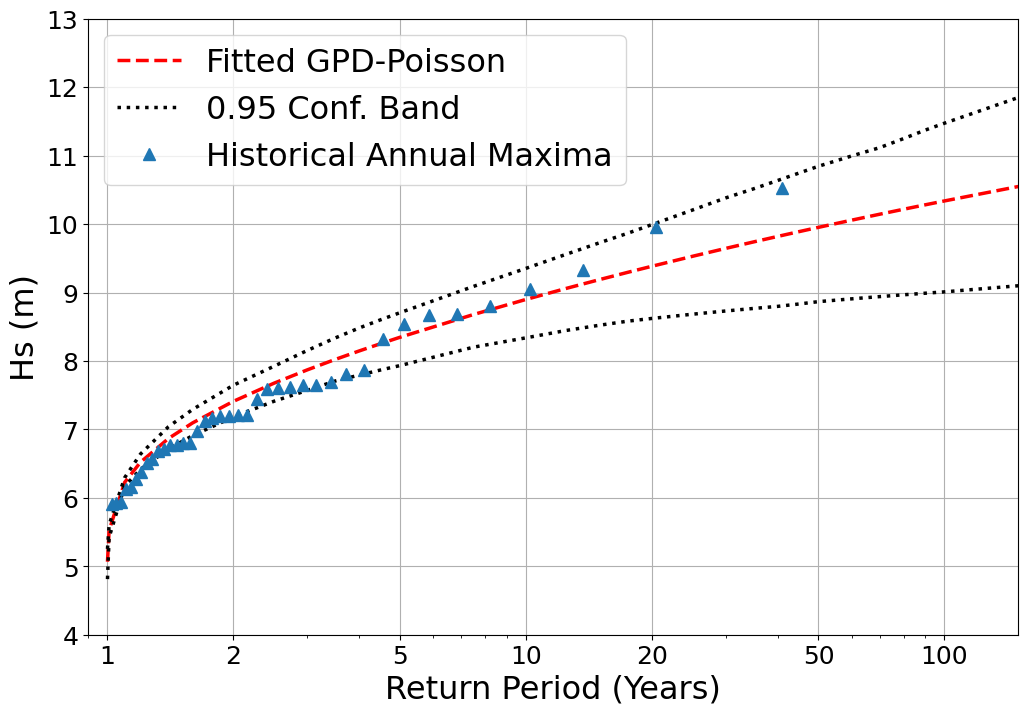

In [13]:
extr_corr_complete.apply_correction(fit_diag=True)
fig, ax = extr_corr_complete.return_period_plot(conf_int_method="bootstrap")
ax.set_ylim(4, 13)
ax.set_xlim(0.9,150)
ax.set_ylabel("Hs (m)", fontsize=23)
ax.set_xlabel("Return Period (Years)", fontsize=23)
ax.legend(loc = "upper left", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.savefig("Figures/SantonaMinAM/Hs/Hs_Historical_ReturnPeriod_REVISED.png", dpi=300, bbox_inches="tight")
plt.show()

In [14]:
extr_corr_complete.test_dist()

{'Statistic': 28.253873657416126, 'P-value': 2.281766442457922e-09}

In [15]:
def q_gev(prob, p):
    """
    Quantile function of GEV
    """
    xi = p[2]
    mu = p[0]
    sigma = p[1]

    if np.abs(xi) < 1e-8:
        return mu - sigma * np.log(-np.log(prob))
    else:
        return mu + (sigma/xi)*((-np.log(prob))**(-xi)-1)

In [16]:
# from src.gev_utils import q_gev
from scipy.stats import genextreme
from scipy import stats

Bootstrap_test = 2000
# Historical parameters estimated
u, sigma, xi = extr_corr_complete.parameters
mu = u + sigma/xi * (extr_corr_complete.poiss_parameter ** xi - 1)
psi = sigma * extr_corr_complete.poiss_parameter ** xi


CvM_statistic = 1/(12*extr_corr_complete.n_sim_year_peaks) + np.sum((np.sort(genextreme.cdf(extr_corr_complete.sim_max_data, c=-xi, loc=mu, scale=psi)) - (2*np.arange(1, extr_corr_complete.n_sim_year_peaks +1) - 1)/(2*extr_corr_complete.n_sim_year_peaks))**2)



# Bootstrap calibration
boot_statistic = np.zeros(Bootstrap_test)

for b in range(Bootstrap_test):
    # 1. Simulate AM of size n_hist from GEV with historical parameters
    uniform_random_hist = np.random.uniform(size=extr_corr_complete.n_year_peaks)
    simulated_am_boot_hist = q_gev(uniform_random_hist, [mu, psi, xi])

    # 2. Fit GEV to simulated AM
    xi_bootfit, mu_bootfit, psi_bootfit = genextreme.fit(simulated_am_boot_hist) # Note xi_bootfit is -xi

    # 3. Simulate AM of size n_sim from GEV with historical parameters
    uniform_random_sim = np.random.uniform(size=extr_corr_complete.n_sim_year_peaks)
    simulated_am_boot_sim = genextreme.ppf(uniform_random_sim, c=xi_bootfit, loc=mu_bootfit, scale=psi_bootfit)

    # 4. Compute bootstrap synthetic AM values using the bootfit
    u_bootfit = genextreme.cdf(simulated_am_boot_sim, c=xi_bootfit, loc=mu_bootfit, scale=psi_bootfit)

    # 5. Compute CvM test for the bootstrap sample
    boot_statistic[b] = 1/(12*extr_corr_complete.n_sim_year_peaks) + np.sum((np.sort(u_bootfit) - (2*np.arange(1, extr_corr_complete.n_sim_year_peaks + 1) - 1)/(2*extr_corr_complete.n_sim_year_peaks))**2)

bootstrap_p_value = (1 + np.sum(boot_statistic >= CvM_statistic)) / (1 + Bootstrap_test)
print(f"Bootstrap p-value of CvM test {bootstrap_p_value}")

Bootstrap p-value of CvM test 0.0004997501249375312


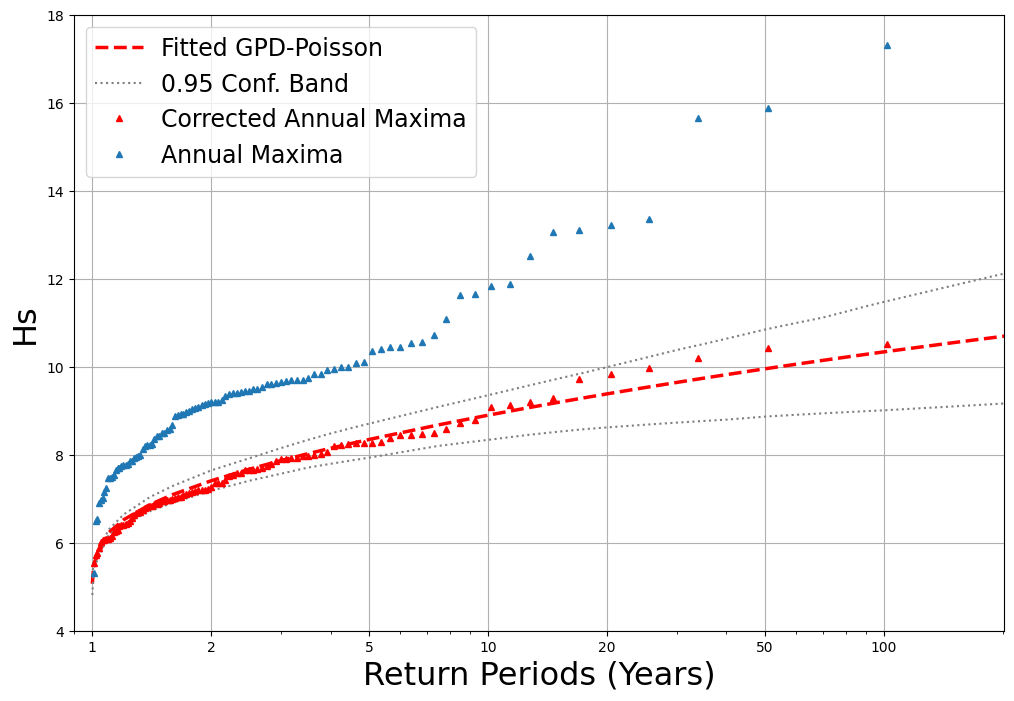

In [18]:
extr_corr_complete.apply_sim_correction()
fig, ax = extr_corr_complete.sim_return_period_plot(show_corrected=True, show_uncorrected=True)
# extr_corr_complete.sim_return_period_plot(show_corrected=True, show_uncorrected=False)
# extr_corr_complete.sim_return_period_plot(show_corrected=False, show_uncorrected=True)

ax.set_ylim(4, 18)
plt.savefig("Figures/SantonaMinAM/Hs/Hs_Simulation_ReturnPeriod_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
extr_corr_complete.poiss_parameter

3.2249293634496925

In [20]:
extr_corr_complete.time_interval_hist

40.000876131441615

In [21]:
extr_corr_complete.n_pit / 362.242

40.332153643144636

In [22]:
extr_corr_complete.n_pot / (extr_corr_complete.n_pit / 362.242)

3.198440657084189

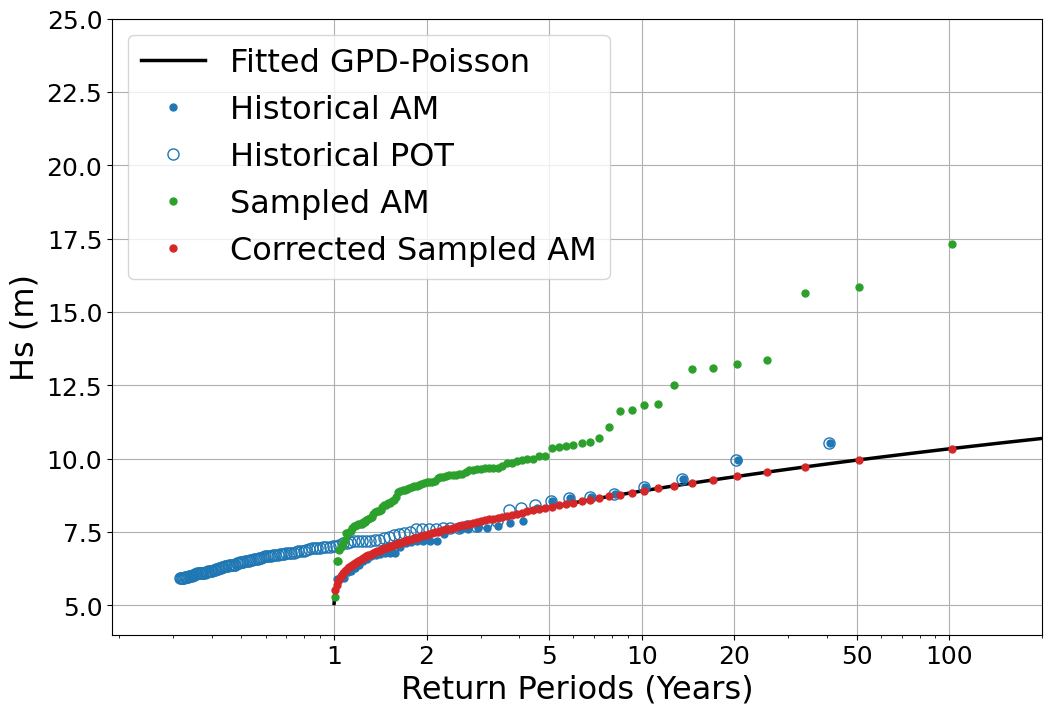

In [23]:

### Plot
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# # Fitted GPD-Poisson
ax.semilogx(extr_corr_complete.ci_T_years, np.sort(extr_corr_complete.x_vals_gpd_poiss_hist), color = 'black', linewidth=2.5, label='Fitted GPD-Poisson')
# # Confidence interval for fitted GPD-Poisson
# ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.upper_pot_ci_return, color = "tab:gray",linestyle='dotted', label=f'{extr_corr_complete.conf} Conf. Band')
# ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.lower_pot_ci_return, color = "tab:gray",linestyle='dotted')



# Historical data
ax.semilogx(extr_corr_complete.T_annmax, extr_corr_complete.max_data_sorted, color="tab:blue", linewidth=0, marker='o',markersize=5, label='Historical AM')
# T_hist_pot = 1 / (1 - (np.arange(1, extr_corr_complete.n_pot + 1) / (extr_corr_complete.n_pot + 1))) / (extr_corr_complete.poiss_parameter)
T_hist_pot = 1 / (1 - (np.arange(1, extr_corr_complete.n_pot + 1) / (extr_corr_complete.n_pot + 1))) / (extr_corr_complete.n_pot / (extr_corr_complete.n_pit / 362.242))
ax.semilogx(T_hist_pot, np.sort(extr_corr_complete.pot_data), color="tab:blue", linewidth=0, marker='o',markersize=8, fillstyle='none', label='Historical POT')



# No corrected data
# ax.semilogx(T_pt_corrected_sim, self.sim_pit_data_sorted, color="tab:blue", linewidth=0, marker='o',markersize=10, fillstyle='none',markerfacecolor='none', markeredgecolor = "tab:blue", label='Daily Data')
# ax.semilogx(T_pot_sim, self.sim_pot_data_sorted, color="orange", linewidth=0, marker='o',markersize=5, label='POT')
# ax.semilogx(T_pot, extr_corr_complete.sim_pot_data_sorted, label="Sampled POT", color="tab:green", linewidth=0, marker='o',markersize=5)
ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_sorted[extr_corr_complete.am_index_0:], color="tab:green", linewidth=0, marker='o',markersize=5, label='Sampled AM')



ecdf_pot = np.arange(1, extr_corr_complete.n_pot_sim + 1) / (extr_corr_complete.n_pot_sim + 1)
T_pot = 1 / (1-ecdf_pot) / extr_corr_complete.poiss_parameter
# Corrected data 
    # ax.semilogx(T_pt_corrected_sim, np.sort(self.sim_pit_data_corrected), linewidth=0, marker='o',markersize=10, fillstyle='none',markerfacecolor='none', markeredgecolor = "tab:blue", label='Corrected Daily Data')
    # ax.semilogx(T_ev_corrected_sim, stats.genpareto.ppf(self.runif_pot_probs_sim, self.parameters[2], loc=self.parameters[0], scale=self.parameters[1]), 
    #             color = 'orange',linewidth=0, marker='o',markersize=5, label=f'Corrected POT')
    # ax.semilogx(self.T_annmax_sim, q_pot(self.ecdf_annmax_probs_sim, self.opt_threshold, self.poiss_parameter, self.gpd_parameters[1], self.gpd_parameters[2]), color = 'red',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
# ax.semilogx(T_pot, np.sort(extr_corr_complete.sim_pit_data_corrected[extr_corr_complete.sim_pot_data_locs]), label="Corrected Sampled POT", color="tab:red", linewidth=0, marker='o',markersize=5)
# ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_corrected_sorted[extr_corr_complete.am_index_0:], color = 'tab:red',linewidth=0, marker='o',markersize=5,label=r'Corrected Sampled AM')

from src.pot_utils import q_pot

sim_max_data_corrected = np.zeros(extr_corr_complete.n_sim_year_peaks)
ecdf_max_probs_sim = np.arange(1, extr_corr_complete.n_sim_year_peaks + 1) / (extr_corr_complete.n_sim_year_peaks + 1)   # ECDF
sim_max_data_corrected[extr_corr_complete.am_index_0:] = q_pot(ecdf_max_probs_sim[extr_corr_complete.am_index_0:], extr_corr_complete.parameters, extr_corr_complete.poiss_parameter)    # Corrected POT
if extr_corr_complete.n_sim_year_peaks > 1:
    sim_aux_pit_corrected = np.interp(
                    extr_corr_complete.sim_pit_data,              # x-coords to interpolate
                    np.append(min(extr_corr_complete.sim_pit_data), extr_corr_complete.sim_max_data_sorted),    # x-coords of data points
                    np.append(min(extr_corr_complete.sim_pit_data), sim_max_data_corrected)  # y-coords of data points 
                )
    sim_pit_data_corrected = sim_aux_pit_corrected
    sim_max_data_corrected_sorted = np.sort(sim_max_data_corrected)

ax.semilogx(extr_corr_complete.T_annmax_sim, sim_max_data_corrected_sorted[extr_corr_complete.am_index_0:], color = 'tab:red',linewidth=0, marker='o',markersize=5,label=r'Corrected Sampled AM')



ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.set_ylabel(f"{extr_corr_complete.var} (m)", fontsize=23)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())   
# ax.set_xlim(right=10000)
ax.set_xlim(left=0.19, right=200)
# ax.set_ylim(bottom=0)
ax.set_ylim(bottom=4, top=25)
ax.legend(loc='upper left', fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.grid()

plt.savefig("Figures/SantonaMinAM/Hs/Hs_HistPOTAM_Deterministic.png", dpi=300, bbox_inches="tight")
plt.show()

In [24]:
extr_corr_complete.parameters

[5.916083812713623, 1.0643346932283722, -0.12091521100810837]

In [25]:
extr_corr_complete.poiss_parameter, extr_corr_complete.sim_poiss_parameter

(3.2249293634496925, 6.35633949579832)

In [26]:
extr_corr_complete.sim_poiss_parameter/extr_corr_complete.poiss_parameter

1.971001153649757

## Loop over correction

In [27]:
dict_maximos_corregidos_Hs = {}
dict_sim_pit_corrected_Hs = {}

for i in range(100):
    
    extr_corr_complete.apply_sim_correction(random_state=i)   # Apply the correction in the simulated data
    # if i == 0:
    #     extr_corr.sim_return_period_plot(show_corrected=True, show_uncorrected=True)                        # Default to plot the corrected and no corrected data
    #     fitted_gev = extr_corr.
    
    
    dict_maximos_corregidos_Hs[i] = extr_corr_complete.sim_max_data_corrected_sorted
    dict_sim_pit_corrected_Hs[i] = extr_corr_complete.sim_pit_data_corrected

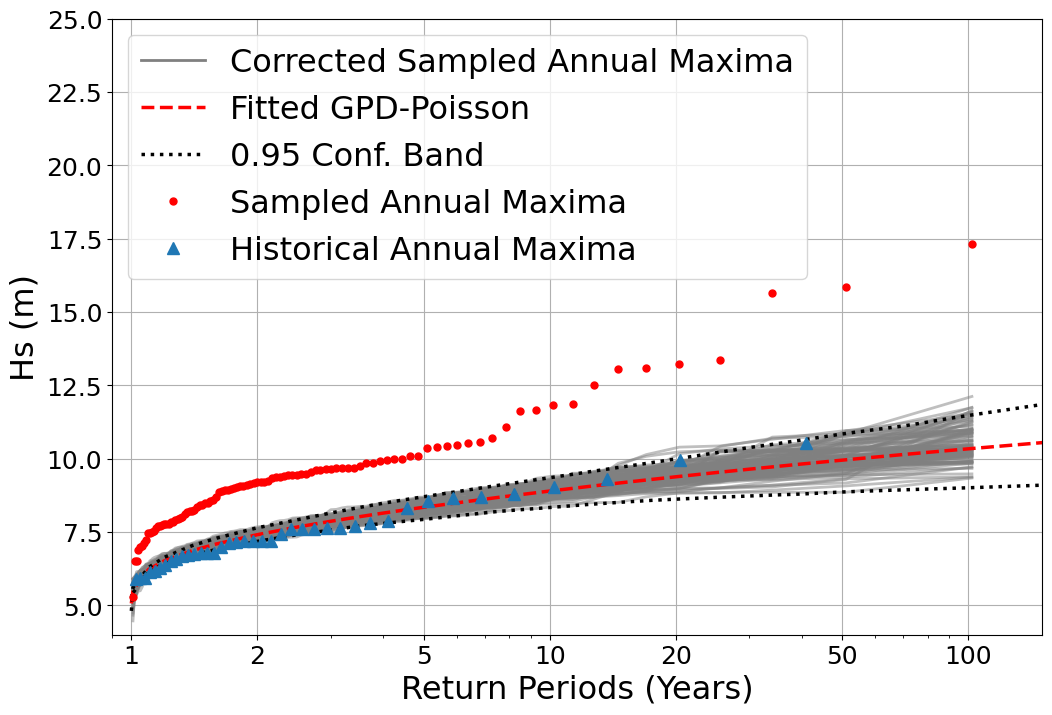

In [28]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# Corrected AM
ax.semilogx(extr_corr_complete.T_annmax_sim, dict_maximos_corregidos_Hs[0], color = 'gray', linewidth=2, alpha=0.5,label='Corrected Sampled Annual Maxima')
for i in range(1,100):
    ax.semilogx(extr_corr_complete.T_annmax_sim, dict_maximos_corregidos_Hs[i], color = 'gray', linewidth=2, alpha=0.5)

# Fitted GPD-Poisson
ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.x_vals_gpd_poiss_sim, color = 'red',linestyle='dashed', linewidth=2.5, label='Fitted GPD-Poisson')
# Confidence interval for fitted GPD-Poisson
ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.upper_pot_ci_return, color = "black",linestyle='dotted', linewidth=2.5, label=f'{extr_corr_complete.conf} Conf. Band')
ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.lower_pot_ci_return, color = "black",linestyle='dotted', linewidth=2.5)


ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_sorted, color="red", linewidth=0, marker='o',markersize=5, label='Sampled Annual Maxima')

ax.semilogx(extr_corr_complete.T_annmax, extr_corr_complete.max_data_sorted, color="tab:blue", linewidth=0, marker='^',markersize=8, label='Historical Annual Maxima')

ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.set_ylabel(f"{extr_corr_complete.var} (m)", fontsize=23)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
# ax.set_xticklabels([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000], fontsize=15)
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
# ax.set_yticklabels(ax.set, fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_xlim(0.9,150)
ax.set_ylim(bottom=4, top=25)
leg = ax.legend(loc='upper left', ncol=1, fontsize=23)
for lh in leg.legend_handles:
    lh.set_alpha(1)
# ax.legend(loc='upper left', fontsize=LEGEND_FONTSIZE)
ax.grid()
plt.savefig("Figures/SantonaMinAM/Hs/Hs_ReturnLevel_Simulated_Ensemble_REVISED.png", dpi=300, bbox_inches="tight")
plt.show()

In [29]:
correlation_hs = extr_corr_complete.correlation()
correlation_hs

{'Spearman': 0.9999999999999998, 'Kendall': 1.0, 'Pearson': 0.9906223331136629}

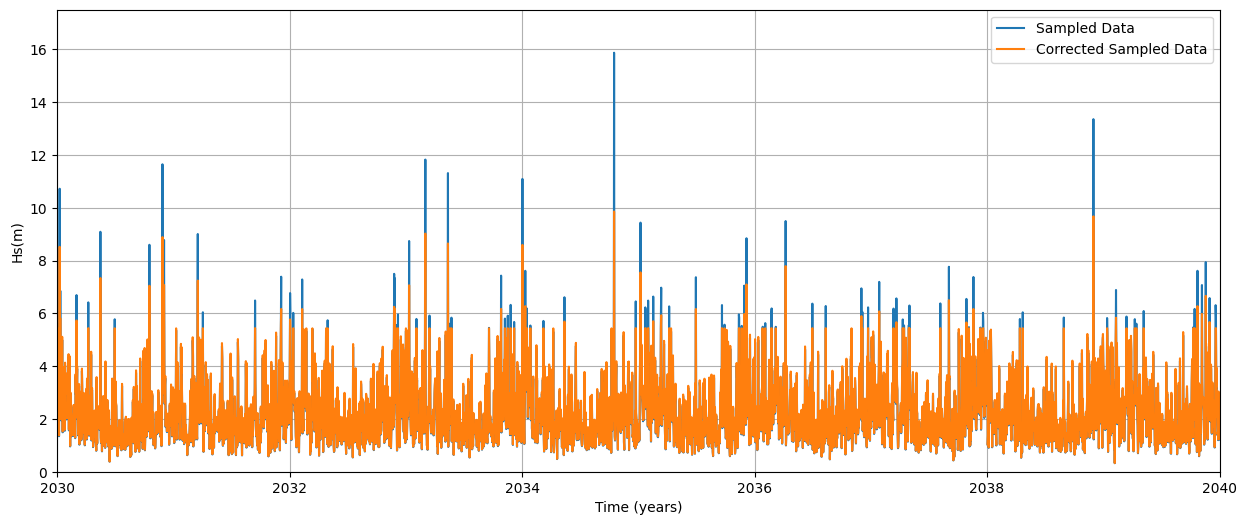

In [30]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete.sim_pit_data, label="Sampled Data", color="tab:blue")
ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete.sim_pit_data_corrected, label="Corrected Sampled Data", color="tab:orange")
# ax.hlines(5.25, xmin=2033, xmax=2035, color="black", linestyles="--")
ax.set_xlim(2030, 2040)
ax.set_ylim(0, 17.5)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Hs(m)")
ax.grid()
ax.legend()
plt.savefig("Figures/SantonaMinAM/Hs/Hs_SimTimeSeries_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

## Simulated Poisson parameter change 

In [31]:
sim_poiss_param_100_hs = np.zeros(100)
for i in range(100):
    sim_pot_corrected_hs, _, _ = extr_corr_complete.obtain_pots(
                dict_sim_pit_corrected_Hs[i],
                threshold=extr_corr_complete.opt_threshold,
                n0 = extr_corr_complete.pot_config['n0'],
                min_peak_distance=extr_corr_complete.pot_config['min_peak_distance'],
                siglevel = extr_corr_complete.pot_config['siglevel'],
                plot_flag = extr_corr_complete.pot_config['plot_flag'],
                optimize_threshold=False
            )
    sim_poiss_param_100_hs[i] = sim_pot_corrected_hs.size / extr_corr_complete.time_interval_sim

In [32]:
print(np.median(sim_poiss_param_100_hs), np.mean(sim_poiss_param_100_hs), np.std(sim_poiss_param_100_hs))

2.9900537815126054 3.3493552773109245 1.2062444489671653


In [33]:
extr_corr_complete.sim_poiss_parameter

6.35633949579832

In [34]:
extr_corr_complete.poiss_parameter

3.2249293634496925

In [35]:
np.quantile(sim_poiss_param_100_hs, [0.025, 0.975])

array([2.03957311, 7.10682319])

In [36]:
def poisson_rate_ci_garwood(k, T, conf=0.95):
    """
    IC exacto (Garwood) para la tasa lambda de un proceso Poisson,
    dado un conteo k observado en una exposición T.

    Retorna: (lambda_hat, lambda_low, lambda_high)
    """
    if T <= 0:
        raise ValueError("T debe ser > 0")
    if k < 0 or int(k) != k:
        raise ValueError("k debe ser un entero >= 0")

    alpha = 1 - conf
    lam_hat = k / T

    # Límite inferior: si k=0, el límite inferior es 0
    if k == 0:
        lam_low = 0.0
    else:
        lam_low = 0.5 * stats.chi2.ppf(alpha / 2, df=2 * k) / T

    # Límite superior
    lam_high = 0.5 * stats.chi2.ppf(1 - alpha / 2, df=2 * (k + 1)) / T

    return lam_hat, lam_low, lam_high

In [37]:
wald_lb = extr_corr_complete.poiss_parameter - 1.96 * np.sqrt(extr_corr_complete.poiss_parameter / extr_corr_complete.time_interval_hist)
wald_ub = extr_corr_complete.poiss_parameter + 1.96 * np.sqrt(extr_corr_complete.poiss_parameter / extr_corr_complete.time_interval_hist)

In [38]:
poiss_hist, poiss_hist_lb, poiss_hist_ub = poisson_rate_ci_garwood(extr_corr_complete.n_pot, extr_corr_complete.time_interval_hist, conf=0.95)
print(f"{np.mean((sim_poiss_param_100_hs >= poiss_hist_lb) & (sim_poiss_param_100_hs <= poiss_hist_ub)) * 100} % of corrected Poisson rates within 95% CI of the historical Poisson rate.")

60.0 % of corrected Poisson rates within 95% CI of the historical Poisson rate.


In [39]:
poiss_hist_lb, poiss_hist_ub

(2.692461744284925, 3.8318809843804913)

In [40]:
wald_lb, wald_ub

(2.6684085351961544, 3.7814501917032306)

In [41]:
print(f"{np.mean((sim_poiss_param_100_hs >= wald_lb) & (sim_poiss_param_100_hs <= wald_ub)) * 100} % of corrected Poisson rates within 95% CI of the historical Poisson rate.")

57.99999999999999 % of corrected Poisson rates within 95% CI of the historical Poisson rate.


Ver el número de datos diarios que hay entre cada bloque y como cambian los bloques

In [42]:
bloques = {}
for j in range(extr_corr_complete.sim_max_data_sorted.size):
    if j == 0:
        bloques[j] = (
            sum((extr_corr_complete.sim_pit_data >= min(extr_corr_complete.sim_pit_data)) & (extr_corr_complete.sim_pit_data < extr_corr_complete.sim_max_data_sorted[j])), 
            (min(extr_corr_complete.sim_pit_data), extr_corr_complete.sim_max_data_sorted[j]), 
            (min(extr_corr_complete.sim_pit_data_corrected), extr_corr_complete.sim_max_data_corrected_sorted[j])
            )
    else:
        bloques[j] = (
            sum((extr_corr_complete.sim_pit_data >= extr_corr_complete.sim_max_data_sorted[j-1]) & (extr_corr_complete.sim_pit_data < extr_corr_complete.sim_max_data_sorted[j])), 
            (extr_corr_complete.sim_max_data_sorted[j-1], extr_corr_complete.sim_max_data_sorted[j]), 
            (extr_corr_complete.sim_max_data_corrected_sorted[j-1], extr_corr_complete.sim_max_data_corrected_sorted[j])
            )

In [43]:
bloques

{0: (35736,
  (0.17059068486300943, 5.301258173546213),
  (0.17059068486300943, 5.430516601392603)),
 1: (694,
  (5.301258173546213, 6.4973464443083495),
  (5.430516601392603, 5.439657293936764)),
 2: (12,
  (6.4973464443083495, 6.528554942439624),
  (5.439657293936764, 5.6438253504113165)),
 3: (117,
  (6.528554942439624, 6.901576514188907),
  (5.6438253504113165, 5.841044481621957)),
 4: (21,
  (6.901576514188907, 6.977285020826242),
  (5.841044481621957, 5.932390538666445)),
 5: (9,
  (6.977285020826242, 7.023372717237794),
  (5.932390538666445, 5.970363146759224)),
 6: (24,
  (7.023372717237794, 7.143926407312166),
  (5.970363146759224, 5.986483222265226)),
 7: (18,
  (7.143926407312166, 7.236446723128276),
  (5.986483222265226, 6.160058140324522)),
 8: (47,
  (7.236446723128276, 7.467809395689405),
  (6.160058140324522, 6.167487672335851)),
 9: (3,
  (7.467809395689405, 7.481819293345467),
  (6.167487672335851, 6.238503755517707)),
 10: (3,
  (7.481819293345467, 7.495418268629498)

In [44]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

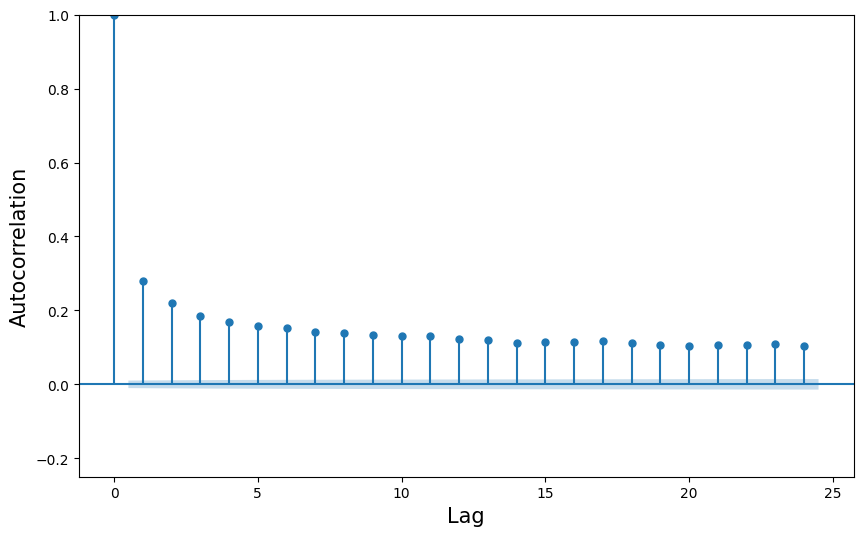

In [45]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_acf(extr_corr_complete.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/SantonaMinAM/Hs/Hs_ACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [46]:
acf_hist, confint_hist = acf(extr_corr_complete.sim_pit_data, nlags=7, alpha=0.05)
acf_sim, confint_sim = acf(extr_corr_complete.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [47]:
import scipy.stats as stats
stats.pearsonr(acf_hist, acf_sim)

PearsonRResult(statistic=0.9999433624848421, pvalue=4.5418640941723085e-13)

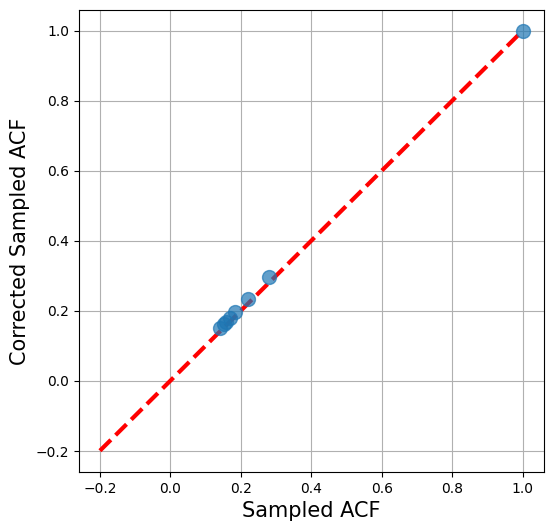

In [48]:
plt.figure(figsize=(6,6))
plt.plot([-0.2,1],[-0.2,1], 'r--', linewidth=3)
plt.plot(acf_hist, acf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled ACF", fontsize=15)
plt.ylabel("Corrected Sampled ACF", fontsize=15)
plt.savefig("Figures/SantonaMinAM/Hs/Hs_ACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

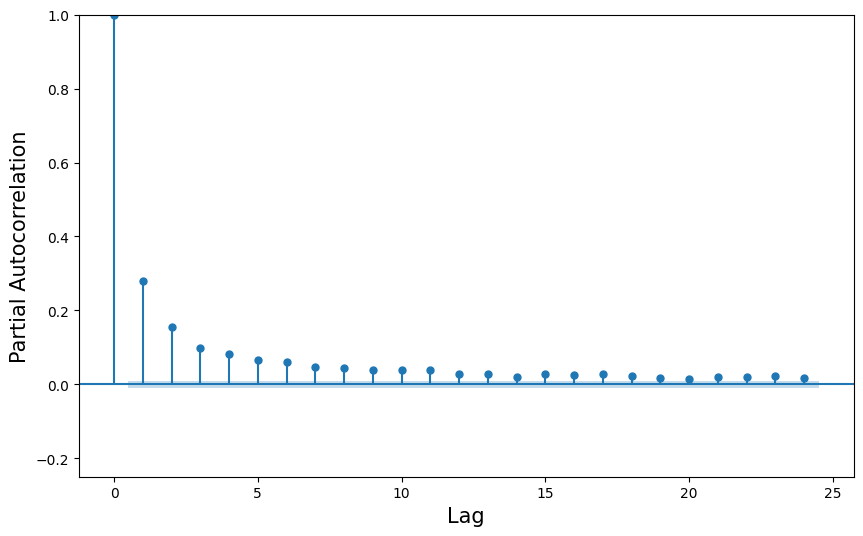

In [49]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_pacf(extr_corr_complete.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Partial Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/SantonaMinAM/Hs/Hs_PACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [50]:
pacf_hist, pconfint_hist = pacf(extr_corr_complete.sim_pit_data, nlags=7, alpha=0.05)
pacf_sim, pconfint_sim = pacf(extr_corr_complete.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [51]:
stats.pearsonr(pacf_hist, pacf_sim)

PearsonRResult(statistic=0.9998612858860292, pvalue=6.672011436617051e-12)

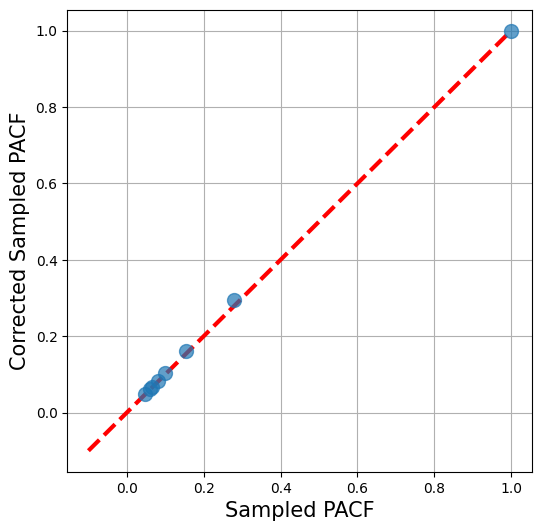

In [52]:
plt.figure(figsize=(6,6))
plt.plot([-0.1,1],[-0.1,1], 'r--', linewidth=3)
plt.plot(pacf_hist, pacf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled PACF", fontsize=15)
plt.ylabel("Corrected Sampled PACF", fontsize=15)
plt.savefig("Figures/SantonaMinAM/Hs/Hs_PACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

QQ-plot between quantiles 0.05 and 0.95 of the whole distribution

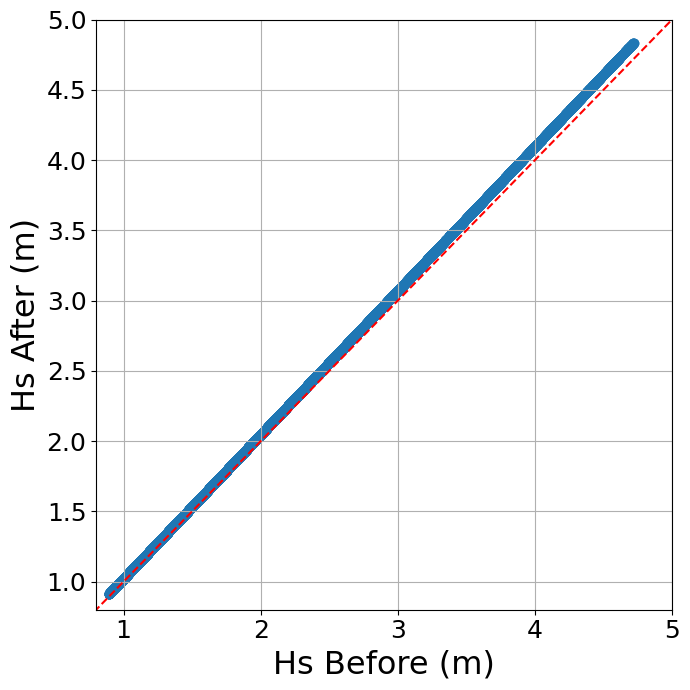

In [53]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    
# QQ plot (top) before
probabilities_qq = (np.arange(1, extr_corr_complete.n_sim_pit + 1)) / (extr_corr_complete.n_sim_pit+1)
mask_probs = (probabilities_qq >= 0.05) & (probabilities_qq <= 0.95)

ax1.scatter(extr_corr_complete.sim_pit_data_sorted[mask_probs], np.sort(extr_corr_complete.sim_pit_data_corrected)[mask_probs], label="Data vs GPD", alpha=0.7)
ax1.plot([0,5], [0,5], 'r--', label="y = x (Reference)")
ax1.set_xlabel("Hs Before (m)", fontsize=23)
ax1.set_ylabel("Hs After (m)", fontsize=23)
ax1.grid()
ax1.set_xlim(0.8, 5)
ax1.set_ylim(0.8, 5)

ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
plt.savefig(f"{extr_corr_complete.folder}/Hs_BeforeAfterCorr.png", dpi=300, bbox_inches='tight')
# plt.close(fig)

# Tp

In [54]:
config_tp = {
    'var': "Tp",
    'time_var': 'time',
    'yyyy_var': 'yyyy',
    'mm_var': 'mm',
    'dd_var': 'dd',
    'freq': 365.242,
    'folder': 'Figures/SantonaMinAM/Tp'
}

pot_config_tp = {
    'n0': 10,
    'min_peak_distance': 2,
    # 'init_threshold': 0.0,
    'init_threshold': df_hist.groupby(["yyyy"])["Tp"].max().min(),
    'siglevel': 0.01,
    'plot_flag': True
}

extr_corr_complete_tp = ExtremeCorrection(
    data_hist = df_hist,
    data_sim = df_sim[:-1],
    config=config_tp,
    pot_config=pot_config_tp,
    method="POT",
    conf_level=0.95,
    random_state=0
)

Poisson parameters difference: 6.128647275090735


In [55]:
extr_corr_complete_tp.opt_threshold

16.50789451599121

In [56]:
ecdf_hist_tp = ECDF(df_hist["Tp"])
ecdf_hist_tp(extr_corr_complete_tp.opt_threshold)

0.9875427789185489

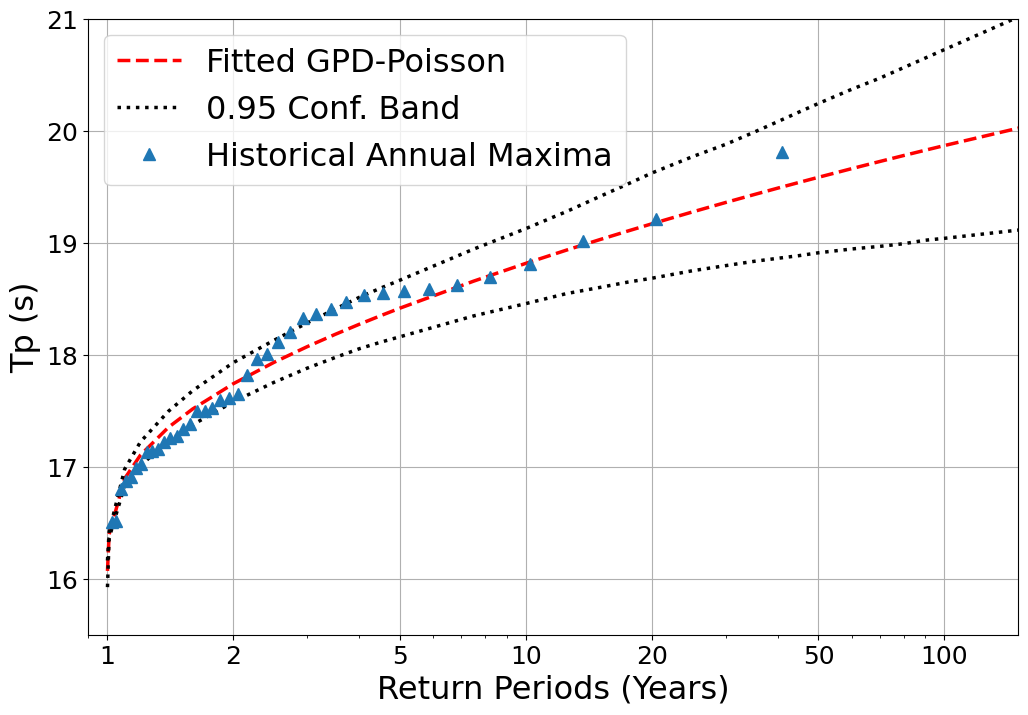

In [57]:
extr_corr_complete_tp.apply_correction(fit_diag=True)
fig, ax = extr_corr_complete_tp.return_period_plot()
ax.set_ylim(15.5, 21)
ax.set_xlim(0.9,150)
ax.set_ylabel("Tp (s)", fontsize=23)
ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.legend(loc = "upper left", fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
plt.savefig("Figures/SantonaMinAM/Tp/Tp_Historical_ReturnPeriod_REVISED.png", dpi=300, bbox_inches="tight")
plt.show()

In [58]:
extr_corr_complete_tp.test_dist()

{'Statistic': 32.34896341044796, 'P-value': 2.4962881761680933e-09}

In [59]:
# from src.gev_utils import q_gev
from scipy.stats import genextreme
from scipy import stats

Bootstrap_test = 2000
# Historical parameters estimated
u, sigma, xi = extr_corr_complete_tp.parameters
mu = u + sigma/xi * (extr_corr_complete_tp.poiss_parameter ** xi - 1)
psi = sigma * extr_corr_complete_tp.poiss_parameter ** xi


CvM_statistic = 1/(12*extr_corr_complete_tp.n_sim_year_peaks) + np.sum((np.sort(genextreme.cdf(extr_corr_complete_tp.sim_max_data, c=-xi, loc=mu, scale=psi)) - (2*np.arange(1, extr_corr_complete_tp.n_sim_year_peaks +1) - 1)/(2*extr_corr_complete_tp.n_sim_year_peaks))**2)



# Bootstrap calibration
boot_statistic = np.zeros(Bootstrap_test)

for b in range(Bootstrap_test):
    # 1. Simulate AM of size n_hist from GEV with historical parameters
    uniform_random_hist = np.random.uniform(size=extr_corr_complete_tp.n_year_peaks)
    simulated_am_boot_hist = q_gev(uniform_random_hist, [mu, psi, xi])

    # 2. Fit GEV to simulated AM
    xi_bootfit, mu_bootfit, psi_bootfit = genextreme.fit(simulated_am_boot_hist) # Note xi_bootfit is -xi

    # 3. Simulate AM of size n_sim from GEV with historical parameters
    uniform_random_sim = np.random.uniform(size=extr_corr_complete_tp.n_sim_year_peaks)
    simulated_am_boot_sim = genextreme.ppf(uniform_random_sim, c=xi_bootfit, loc=mu_bootfit, scale=psi_bootfit)

    # 4. Compute bootstrap synthetic AM values using the bootfit
    u_bootfit = genextreme.cdf(simulated_am_boot_sim, c=xi_bootfit, loc=mu_bootfit, scale=psi_bootfit)

    # 5. Compute CvM test for the bootstrap sample
    boot_statistic[b] = 1/(12*extr_corr_complete_tp.n_sim_year_peaks) + np.sum((np.sort(u_bootfit) - (2*np.arange(1, extr_corr_complete_tp.n_sim_year_peaks + 1) - 1)/(2*extr_corr_complete_tp.n_sim_year_peaks))**2)

bootstrap_p_value = (1 + np.sum(boot_statistic >= CvM_statistic)) / (1 + Bootstrap_test)
print(f"Bootstrap p-value of CvM test {bootstrap_p_value}")

Bootstrap p-value of CvM test 0.0004997501249375312


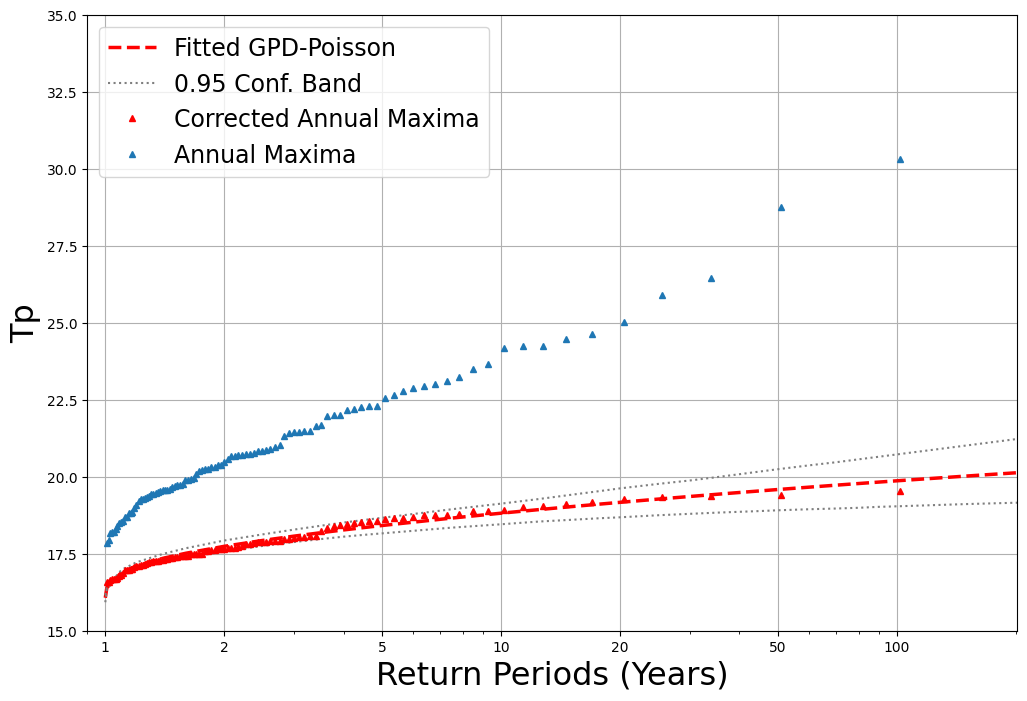

In [60]:
extr_corr_complete_tp.apply_sim_correction()
fig, ax = extr_corr_complete_tp.sim_return_period_plot(show_corrected=True, show_uncorrected=True)
# extr_corr_complete_tp.sim_return_period_plot(show_corrected=True, show_uncorrected=False)
# extr_corr_complete_tp.sim_return_period_plot(show_corrected=False, show_uncorrected=True)

ax.set_ylim(15, 35)
plt.savefig("Figures/SantonaMinAM/Tp/Tp_Simulation_ReturnPeriod_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

In [61]:
extr_corr_complete_tp.parameters

[16.50789451599121, 0.7770086277540037, -0.11529649230270995]

In [62]:
extr_corr_complete_tp.poiss_parameter, extr_corr_complete_tp.sim_poiss_parameter

(3.999912388774812, 10.128559663865547)

In [63]:
extr_corr_complete_tp.sim_poiss_parameter/ extr_corr_complete_tp.poiss_parameter

2.5321953781512603

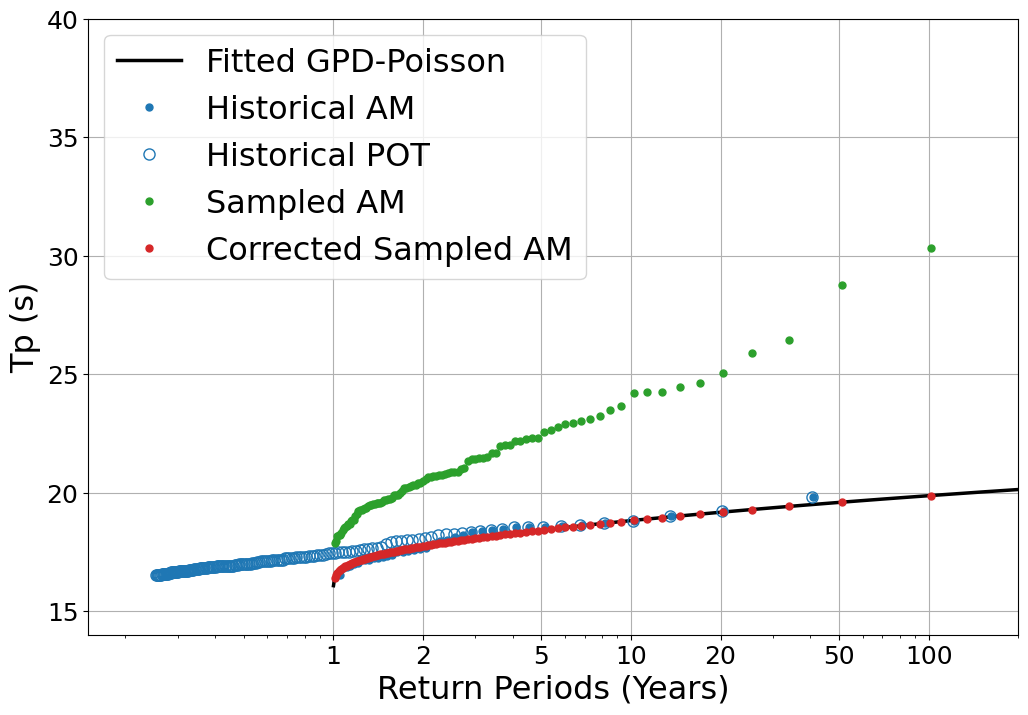

In [64]:

### Plot
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# # Fitted GPD-Poisson
ax.semilogx(extr_corr_complete_tp.ci_T_years, np.sort(extr_corr_complete_tp.x_vals_gpd_poiss_hist), color = 'black', linewidth=2.5, label='Fitted GPD-Poisson')
# # Confidence interval for fitted GPD-Poisson
# ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.upper_pot_ci_return, color = "tab:gray",linestyle='dotted', label=f'{extr_corr_complete.conf} Conf. Band')
# ax.semilogx(extr_corr_complete.ci_T_years, extr_corr_complete.lower_pot_ci_return, color = "tab:gray",linestyle='dotted')



# Historical data
ax.semilogx(extr_corr_complete_tp.T_annmax, extr_corr_complete_tp.max_data_sorted, color="tab:blue", linewidth=0, marker='o',markersize=5, label='Historical AM')
# T_hist_pot = 1 / (1 - (np.arange(1, extr_corr_complete.n_pot + 1) / (extr_corr_complete.n_pot + 1))) / (extr_corr_complete.poiss_parameter)
T_hist_pot = 1 / (1 - (np.arange(1, extr_corr_complete_tp.n_pot + 1) / (extr_corr_complete_tp.n_pot + 1))) / (extr_corr_complete_tp.n_pot / (extr_corr_complete_tp.n_pit / 362.242))
ax.semilogx(T_hist_pot, np.sort(extr_corr_complete_tp.pot_data), color="tab:blue", linewidth=0, marker='o',markersize=8, fillstyle='none', label='Historical POT')



# No corrected data
# ax.semilogx(T_pt_corrected_sim, self.sim_pit_data_sorted, color="tab:blue", linewidth=0, marker='o',markersize=10, fillstyle='none',markerfacecolor='none', markeredgecolor = "tab:blue", label='Daily Data')
# ax.semilogx(T_pot_sim, self.sim_pot_data_sorted, color="orange", linewidth=0, marker='o',markersize=5, label='POT')
# ax.semilogx(T_pot, extr_corr_complete.sim_pot_data_sorted, label="Sampled POT", color="tab:green", linewidth=0, marker='o',markersize=5)
ax.semilogx(extr_corr_complete_tp.T_annmax_sim, extr_corr_complete_tp.sim_max_data_sorted[extr_corr_complete_tp.am_index_0:], color="tab:green", linewidth=0, marker='o',markersize=5, label='Sampled AM')



ecdf_pot = np.arange(1, extr_corr_complete_tp.n_pot_sim + 1) / (extr_corr_complete_tp.n_pot_sim + 1)
T_pot = 1 / (1-ecdf_pot) / extr_corr_complete_tp.poiss_parameter
# Corrected data 
    # ax.semilogx(T_pt_corrected_sim, np.sort(self.sim_pit_data_corrected), linewidth=0, marker='o',markersize=10, fillstyle='none',markerfacecolor='none', markeredgecolor = "tab:blue", label='Corrected Daily Data')
    # ax.semilogx(T_ev_corrected_sim, stats.genpareto.ppf(self.runif_pot_probs_sim, self.parameters[2], loc=self.parameters[0], scale=self.parameters[1]), 
    #             color = 'orange',linewidth=0, marker='o',markersize=5, label=f'Corrected POT')
    # ax.semilogx(self.T_annmax_sim, q_pot(self.ecdf_annmax_probs_sim, self.opt_threshold, self.poiss_parameter, self.gpd_parameters[1], self.gpd_parameters[2]), color = 'red',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
# ax.semilogx(T_pot, np.sort(extr_corr_complete.sim_pit_data_corrected[extr_corr_complete.sim_pot_data_locs]), label="Corrected Sampled POT", color="tab:red", linewidth=0, marker='o',markersize=5)
# ax.semilogx(extr_corr_complete.T_annmax_sim, extr_corr_complete.sim_max_data_corrected_sorted[extr_corr_complete.am_index_0:], color = 'tab:red',linewidth=0, marker='o',markersize=5,label=r'Corrected Sampled AM')

from src.pot_utils import q_pot

sim_max_data_corrected = np.zeros(extr_corr_complete_tp.n_sim_year_peaks)
ecdf_max_probs_sim = np.arange(1, extr_corr_complete_tp.n_sim_year_peaks + 1) / (extr_corr_complete_tp.n_sim_year_peaks + 1)   # ECDF
sim_max_data_corrected[extr_corr_complete_tp.am_index_0:] = q_pot(ecdf_max_probs_sim[extr_corr_complete_tp.am_index_0:], extr_corr_complete_tp.parameters, extr_corr_complete_tp.poiss_parameter)    # Corrected POT
if extr_corr_complete_tp.n_sim_year_peaks > 1:
    sim_aux_pit_corrected = np.interp(
                    extr_corr_complete_tp.sim_pit_data,              # x-coords to interpolate
                    np.append(min(extr_corr_complete_tp.sim_pit_data), extr_corr_complete_tp.sim_max_data_sorted),    # x-coords of data points
                    np.append(min(extr_corr_complete_tp.sim_pit_data), sim_max_data_corrected)  # y-coords of data points 
                )
    sim_pit_data_corrected = sim_aux_pit_corrected
    sim_max_data_corrected_sorted = np.sort(sim_max_data_corrected)

ax.semilogx(extr_corr_complete_tp.T_annmax_sim, sim_max_data_corrected_sorted[extr_corr_complete_tp.am_index_0:], color = 'tab:red',linewidth=0, marker='o',markersize=5,label=r'Corrected Sampled AM')



ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.set_ylabel(f"{extr_corr_complete_tp.var} (s)", fontsize=23)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())   
# ax.set_xlim(right=10000)
ax.set_xlim(left=0.15, right=200)
# ax.set_ylim(bottom=0)
ax.set_ylim(bottom=14, top=40)
ax.legend(loc='upper left', fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.grid()
plt.savefig("Figures/SantonaMinAM/Tp/Tp_HistPOTAM_Deterministic.png", dpi=300, bbox_inches="tight")

plt.show()

## Loop over correction

In [65]:
dict_maximos_corregidos_Tp = {}
dict_sim_pit_corrected_Tp = {}
for i in range(100):
    
    extr_corr_complete_tp.apply_sim_correction(random_state=i)   # Apply the correction in the simulated data
    # if i == 0:
    #     extr_corr.sim_return_period_plot(show_corrected=True, show_uncorrected=True)                        # Default to plot the corrected and no corrected data
    #     fitted_gev = extr_corr.
    
    dict_maximos_corregidos_Tp[i] = extr_corr_complete_tp.sim_max_data_corrected_sorted
    dict_sim_pit_corrected_Tp[i] = extr_corr_complete_tp.sim_pit_data_corrected

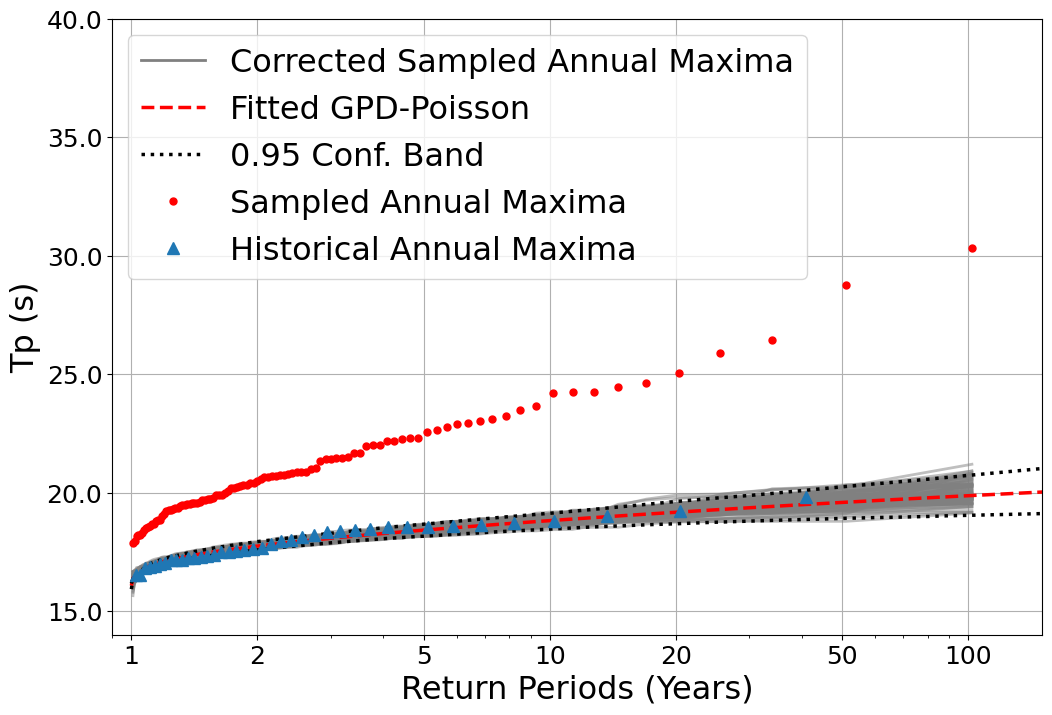

In [66]:
fig = plt.figure(figsize=(12,8))
ax= fig.add_subplot()

# Corrected AM
ax.semilogx(extr_corr_complete_tp.T_annmax_sim, dict_maximos_corregidos_Tp[0], color = 'gray', linewidth=2, alpha=0.5,label='Corrected Sampled Annual Maxima')
for i in range(1,100):
    ax.semilogx(extr_corr_complete_tp.T_annmax_sim, dict_maximos_corregidos_Tp[i], color = 'gray', linewidth=2, alpha=0.5)

# Fitted GPD-Poisson
ax.semilogx(extr_corr_complete_tp.ci_T_years, extr_corr_complete_tp.x_vals_gpd_poiss_hist, color = 'red',linestyle='dashed', linewidth=2.5, label='Fitted GPD-Poisson')
# Confidence interval for fitted GPD-Poisson
ax.semilogx(extr_corr_complete_tp.ci_T_years, extr_corr_complete_tp.upper_pot_ci_return, color = "black",linestyle='dotted', linewidth=2.5, label=f'{extr_corr_complete_tp.conf} Conf. Band')
ax.semilogx(extr_corr_complete_tp.ci_T_years, extr_corr_complete_tp.lower_pot_ci_return, color = "black",linestyle='dotted', linewidth=2.5)


ax.semilogx(extr_corr_complete_tp.T_annmax_sim, extr_corr_complete_tp.sim_max_data_sorted, color="red", linewidth=0, marker='o',markersize=5, label='Sampled Annual Maxima')

ax.semilogx(extr_corr_complete_tp.T_annmax, extr_corr_complete_tp.max_data_sorted, color="tab:blue", linewidth=0, marker='^',markersize=8, label='Historical Annual Maxima')

ax.set_xlabel("Return Periods (Years)", fontsize=23)
ax.set_ylabel(f"{extr_corr_complete_tp.var} (s)", fontsize=23)
# ax.set_title(f"Simulated Return Period ({self.var})", fontsize=TITLE_FONTSIZE)
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.set_xlim(0.9,150)
ax.set_ylim(bottom=14, top=40)
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
leg = ax.legend(loc='best', ncol=1, fontsize=23)
for lh in leg.legend_handles:
    lh.set_alpha(1)
# ax.legend(loc='upper left', fontsize=LEGEND_FONTSIZE)
ax.grid()
plt.savefig("Figures/SantonaMinAM/Tp/Tp_ReturnLevel_Simulated_Ensemble_REVISED.png", dpi=300, bbox_inches="tight")
plt.show()

In [67]:
extr_corr_complete_tp.correlation()

{'Spearman': 0.9999999999999998, 'Kendall': 1.0, 'Pearson': 0.9989786129569906}

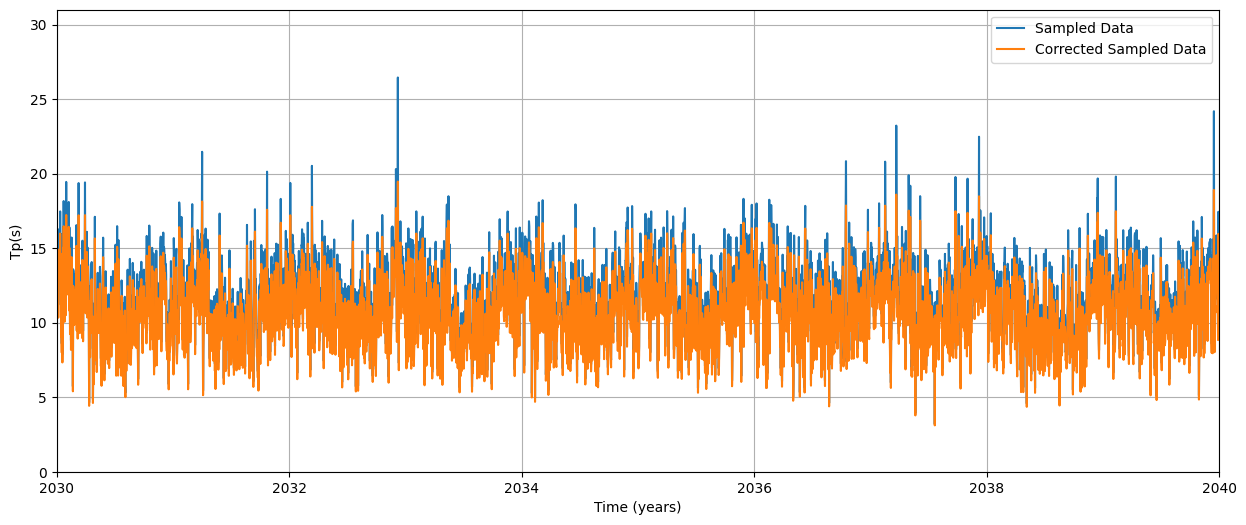

In [68]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete_tp.sim_pit_data, label="Sampled Data")
ax.plot(df_sim["time"].values[:-1]+df_sim["yyyy"].min(), extr_corr_complete_tp.sim_pit_data_corrected, label="Corrected Sampled Data")
ax.set_xlim(2030, 2040)
ax.set_ylim(0, 31)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Tp(s)")
ax.grid()
ax.legend()
plt.savefig("Figures/SantonaMinAM/Tp/Tp_SimTimeSeries_Corr_NoCorr.png", dpi=300, bbox_inches="tight")
plt.show()

## Simulated Poisson parameter change between simulations

In [69]:
sim_poiss_param_100_tp = np.zeros(100)
for i in range(100):
    sim_pot_corrected_tp, _, _ = extr_corr_complete_tp.obtain_pots(
                dict_sim_pit_corrected_Tp[i],
                threshold=extr_corr_complete_tp.opt_threshold,
                n0 = extr_corr_complete_tp.pot_config['n0'],
                min_peak_distance=extr_corr_complete_tp.pot_config['min_peak_distance'],
                siglevel = extr_corr_complete_tp.pot_config['siglevel'],
                plot_flag = extr_corr_complete_tp.pot_config['plot_flag'],
                optimize_threshold=False
            )
    sim_poiss_param_100_tp[i] = sim_pot_corrected_tp.size / extr_corr_complete_tp.time_interval_sim

In [70]:
print(np.median(sim_poiss_param_100_tp), np.mean(sim_poiss_param_100_tp), np.std(sim_poiss_param_100_tp))

3.2771781512605043 3.322821025210083 0.4623213164820798


In [71]:
extr_corr_complete_tp.sim_poiss_parameter

10.128559663865547

In [72]:
extr_corr_complete_tp.poiss_parameter

3.999912388774812

In [73]:
np.quantile(sim_poiss_param_100_tp, [0.025, 0.975])

array([2.84154118, 4.35265693])

In [74]:
poiss_hist, poiss_hist_lb, poiss_hist_ub = poisson_rate_ci_garwood(extr_corr_complete.n_pot, extr_corr_complete.time_interval_hist, conf=0.95)
print(f"{np.mean((sim_poiss_param_100_tp >= poiss_hist_lb) & (sim_poiss_param_100_tp <= poiss_hist_ub)) * 100} % of corrected Poisson rates within 95% CI of the historical Poisson rate.")

84.0 % of corrected Poisson rates within 95% CI of the historical Poisson rate.


In [75]:
wald_lb = extr_corr_complete_tp.poiss_parameter - 1.96 * np.sqrt(extr_corr_complete_tp.poiss_parameter / extr_corr_complete_tp.time_interval_hist)
wald_ub = extr_corr_complete_tp.poiss_parameter + 1.96 * np.sqrt(extr_corr_complete_tp.poiss_parameter / extr_corr_complete_tp.time_interval_hist)

In [76]:
poiss_hist_lb, poiss_hist_ub

(2.692461744284925, 3.8318809843804913)

In [77]:
wald_lb, wald_ub

(3.380119542881799, 4.619705234667825)

In [78]:
print(f"{np.mean((sim_poiss_param_100_tp >= wald_lb) & (sim_poiss_param_100_tp <= wald_ub)) * 100} % of corrected Poisson rates within 95% CI of the historical Poisson rate.")

45.0 % of corrected Poisson rates within 95% CI of the historical Poisson rate.


In [79]:
bloques = {}
for j in range(extr_corr_complete_tp.sim_max_data_sorted.size):
    if j == 0:
        bloques[j] = (
            sum((extr_corr_complete_tp.sim_pit_data >= min(extr_corr_complete_tp.sim_pit_data)) & (extr_corr_complete_tp.sim_pit_data < extr_corr_complete_tp.sim_max_data_sorted[j])), 
            (min(extr_corr_complete_tp.sim_pit_data), extr_corr_complete_tp.sim_max_data_sorted[j]), 
            (min(extr_corr_complete_tp.sim_pit_data_corrected), extr_corr_complete_tp.sim_max_data_corrected_sorted[j])
            )
    else:
        bloques[j] = (
            sum((extr_corr_complete_tp.sim_pit_data >= extr_corr_complete_tp.sim_max_data_sorted[j-1]) & (extr_corr_complete_tp.sim_pit_data < extr_corr_complete_tp.sim_max_data_sorted[j])), 
            (extr_corr_complete_tp.sim_max_data_sorted[j-1], extr_corr_complete_tp.sim_max_data_sorted[j]), 
            (extr_corr_complete_tp.sim_max_data_corrected_sorted[j-1], extr_corr_complete_tp.sim_max_data_corrected_sorted[j])
            )

In [80]:
bloques

{0: (36484,
  (2.3518926411971, 17.850811503524792),
  (2.3518926411971, 16.32781598075522)),
 1: (41,
  (17.850811503524792, 17.956235225790262),
  (16.32781598075522, 16.3343093382839)),
 2: (63,
  (17.956235225790262, 18.175428787397607),
  (16.3343093382839, 16.479424116062134)),
 3: (3,
  (18.175428787397607, 18.19710327573736),
  (16.479424116062134, 16.61974397229105)),
 4: (4,
  (18.19710327573736, 18.220296343180422),
  (16.61974397229105, 16.684784880135584)),
 5: (16,
  (18.220296343180422, 18.311216434209072),
  (16.684784880135584, 16.71183165163205)),
 6: (16,
  (18.311216434209072, 18.40768419150487),
  (16.71183165163205, 16.72331515540742)),
 7: (13,
  (18.40768419150487, 18.48547739319836),
  (16.72331515540742, 16.847028021782734)),
 8: (8,
  (18.48547739319836, 18.538906402633486),
  (16.847028021782734, 16.852325892835456)),
 9: (4,
  (18.538906402633486, 18.577365591007776),
  (16.852325892835456, 16.902977058352928)),
 10: (21,
  (18.577365591007776, 18.686928096

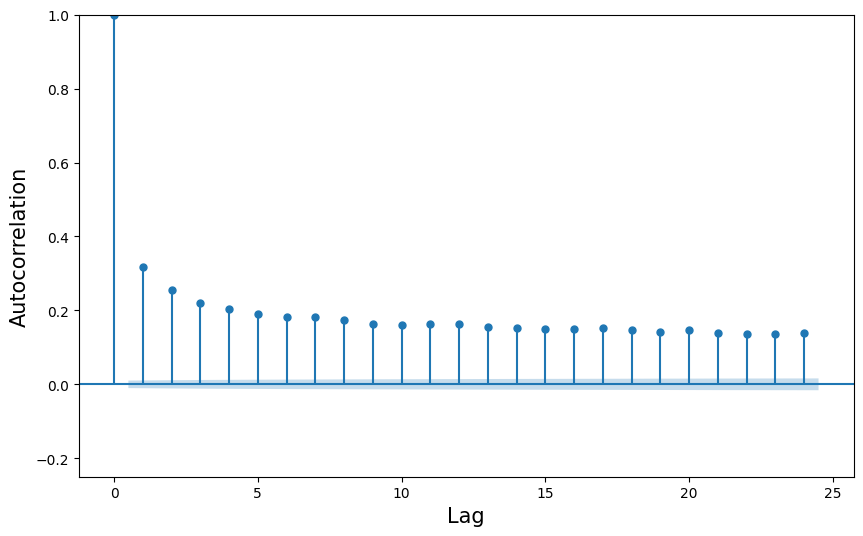

In [81]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_acf(extr_corr_complete_tp.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/SantonaMinAM/Tp/Tp_ACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [82]:
acf_hist, confint_hist = acf(extr_corr_complete_tp.sim_pit_data, nlags=7, alpha=0.05)
acf_sim, confint_sim = acf(extr_corr_complete_tp.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [83]:
stats.pearsonr(acf_hist, acf_sim)

PearsonRResult(statistic=0.9999967840677433, pvalue=8.314949895693479e-17)

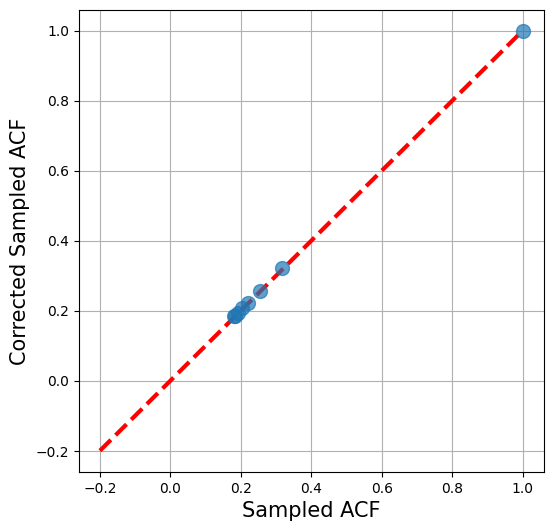

In [84]:
plt.figure(figsize=(6,6))
plt.plot([-0.2,1],[-0.2,1], 'r--', linewidth=3)
plt.plot(acf_hist, acf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled ACF", fontsize=15)
plt.ylabel("Corrected Sampled ACF", fontsize=15)
plt.savefig("Figures/SantonaMinAM/Tp/Tp_ACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

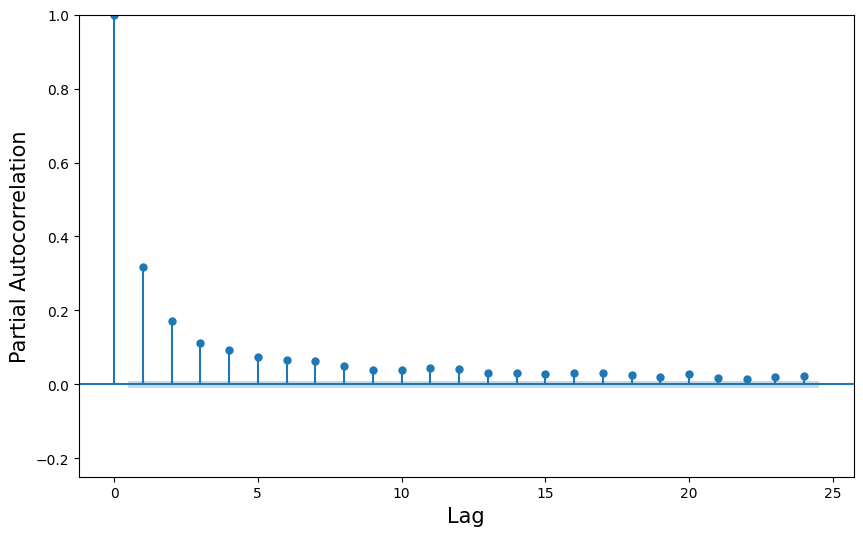

In [85]:
plt.rc("figure", figsize=(10,6))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plot_pacf(extr_corr_complete_tp.sim_pit_data, ax=ax, lags=24, alpha=0.05)
ax.set_title("")
ax.set_xlabel("Lag", fontsize=15)
ax.set_ylabel("Partial Autocorrelation", fontsize=15)
ax.set_ylim(-0.25)
plt.savefig("Figures/SantonaMinAM/Tp/Tp_PACF_sim.png", dpi=300, bbox_inches='tight')
plt.show()

In [86]:
pacf_hist, pconfint_hist = pacf(extr_corr_complete_tp.sim_pit_data, nlags=7, alpha=0.05)
pacf_sim, pconfint_sim = pacf(extr_corr_complete_tp.sim_pit_data_corrected, nlags=7, alpha=0.05)

In [87]:
stats.pearsonr(pacf_hist, pacf_sim)

PearsonRResult(statistic=0.999993473720377, pvalue=6.949201671040982e-16)

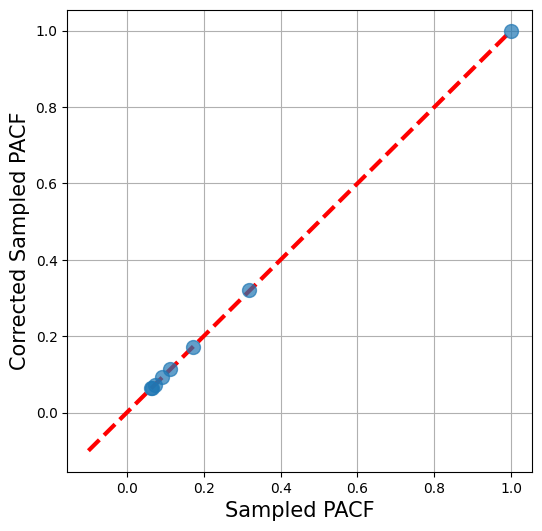

In [88]:
plt.figure(figsize=(6,6))
plt.plot([-0.1,1],[-0.1,1], 'r--', linewidth=3)
plt.plot(pacf_hist, pacf_sim, linewidth=0, marker="o", markersize=10, alpha=0.7)
plt.grid()
plt.xlabel("Sampled PACF", fontsize=15)
plt.ylabel("Corrected Sampled PACF", fontsize=15)
plt.savefig("Figures/SantonaMinAM/Tp/Tp_PACF_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

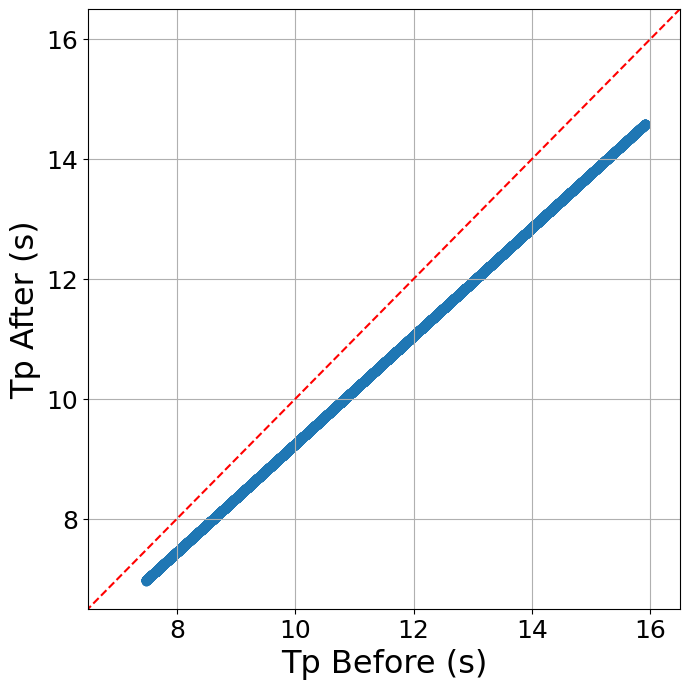

In [89]:
fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    
# QQ plot (top) before
probabilities_qq = (np.arange(1, extr_corr_complete_tp.n_sim_pit + 1)) / (extr_corr_complete_tp.n_sim_pit+1)
mask_probs = (probabilities_qq >= 0.05) & (probabilities_qq <= 0.95)

ax1.scatter(extr_corr_complete_tp.sim_pit_data_sorted[mask_probs], np.sort(extr_corr_complete_tp.sim_pit_data_corrected)[mask_probs], label="Data vs GPD", alpha=0.7)
ax1.plot([0,20], [0,20], 'r--', label="y = x (Reference)")
ax1.set_xlabel("Tp Before (s)", fontsize=23)
ax1.set_ylabel("Tp After (s)", fontsize=23)
ax1.grid()
ax1.set_xlim(6.5, 16.5)
ax1.set_ylim(6.5, 16.5)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
plt.tight_layout()
plt.savefig(f"{extr_corr_complete_tp.folder}/Tp_BeforeAfterCorr.png", dpi=300, bbox_inches='tight')
# plt.close(fig)

# Correlation between series

In [90]:
spear_corr_before= stats.spearmanr(extr_corr_complete.sim_pit_data, extr_corr_complete_tp.sim_pit_data)[0]
spear_corr_after = stats.spearmanr(extr_corr_complete.sim_pit_data_corrected, extr_corr_complete_tp.sim_pit_data_corrected)[0]
kendall_corr_before= stats.kendalltau(extr_corr_complete.sim_pit_data, extr_corr_complete_tp.sim_pit_data)[0]
kendall_corr_after= stats.kendalltau(extr_corr_complete.sim_pit_data_corrected, extr_corr_complete_tp.sim_pit_data_corrected)[0]
pearson_corr_before= stats.pearsonr(extr_corr_complete.sim_pit_data, extr_corr_complete_tp.sim_pit_data)[0]
pearson_corr_after= stats.pearsonr(extr_corr_complete.sim_pit_data_corrected, extr_corr_complete_tp.sim_pit_data_corrected)[0]

print(f"Spearman {spear_corr_before} -> {spear_corr_after}")
print(f"Kendall {kendall_corr_before} -> {kendall_corr_after}")
print(f"Pearson {pearson_corr_before} -> {pearson_corr_after}")

Spearman 0.531681781803654 -> 0.531681781803654
Kendall 0.3707662987350247 -> 0.3707662987350247
Pearson 0.5066222650234152 -> 0.5214646572225402


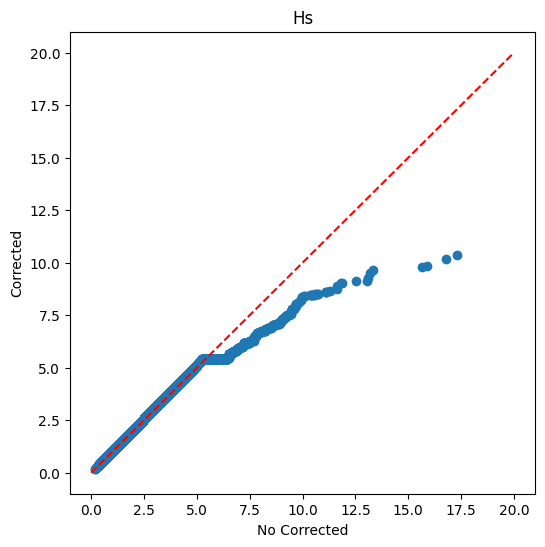

In [91]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(extr_corr_complete.sim_pit_data, extr_corr_complete.sim_pit_data_corrected)

ax.plot([0, 20], [0,20], "--r")
ax.set_title("Hs")
ax.set_xlabel("No Corrected")
ax.set_ylabel("Corrected")
plt.show()


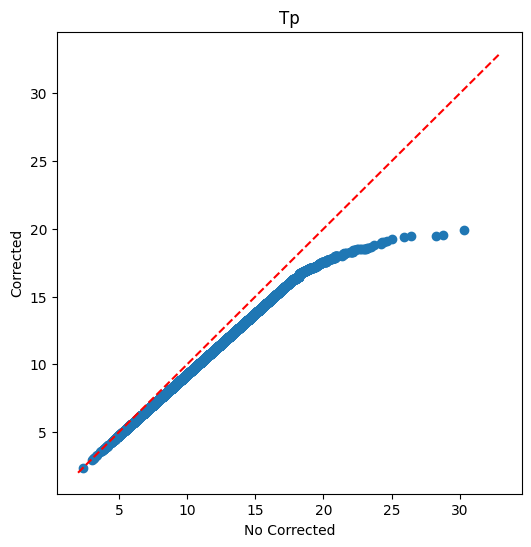

In [92]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()

ax.scatter(extr_corr_complete_tp.sim_pit_data, extr_corr_complete_tp.sim_pit_data_corrected)

ax.plot([2, 33], [2,33], "--r")
ax.set_title("Tp")
ax.set_xlabel("No Corrected")
ax.set_ylabel("Corrected")
plt.show()


Bivariate comparative

$$ 
\hat{\chi}(u)=\frac{\#\lbrace i: \hat{U}_i > u, \hat{V}_i > u \rbrace}{\#\lbrace i: \hat{U}_i > u\rbrace}, \quad u\in\lbrace 0.95, 0.97, 0.99\rbrace
$$

In [93]:
from statsmodels.distributions.empirical_distribution import ECDF

In [94]:
unified_threshold = 0.99

ecdf_hs_before = ECDF(extr_corr_complete.sim_pit_data)
ecdf_hs_after = ECDF(extr_corr_complete.sim_pit_data_corrected)

ecdf_tp_before = ECDF(extr_corr_complete_tp.sim_pit_data)
ecdf_tp_after = ECDF(extr_corr_complete_tp.sim_pit_data_corrected)

xi_before = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) > unified_threshold)) / np.sum(ecdf_hs_before(extr_corr_complete.sim_pit_data) > unified_threshold)

xi_after = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) > unified_threshold)) / np.sum(ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) > unified_threshold)
xi_before, xi_after

(0.0921409214092141, 0.0921409214092141)

$$
\hat{C}(u,u) = \frac{1}{n}\sum_{i=1}^{n}\textbf{1}\lbrace \hat{U}_i \leq u, \hat{V}_i \leq u\rbrace, \quad \hat{\theta}(u) = \frac{\log{(\hat{C}(u,u))}}{\log{(u)}}.
$$

In [95]:
c_uu_before = np.sum((ecdf_hs_before(extr_corr_complete.sim_pit_data) <= unified_threshold) & (ecdf_tp_before(extr_corr_complete_tp.sim_pit_data) <= unified_threshold)) / extr_corr_complete.n_sim_pit
theta_before = np.log(c_uu_before) / np.log(unified_threshold)

c_uu_after = np.sum((ecdf_hs_after(extr_corr_complete.sim_pit_data_corrected) <= unified_threshold) & (ecdf_tp_after(extr_corr_complete_tp.sim_pit_data_corrected) <= unified_threshold)) / extr_corr_complete.n_sim_pit
theta_after = np.log(c_uu_after) / np.log(unified_threshold)

theta_before, theta_after

(1.9171705495758768, 1.9171705495758768)